## A practical guide to MCMC 
### Andy Connolly (University of Washington) - ajc@astro.washington.edu
 <br />
### The objectives of this lecture
- A gentle (re)introduction to MCMC (from a mathematical and intuative perspective)
- **An overview of probablistic programming**
- **Hands on exercises using PYMC3 (from fitting a distribution to fitting data of increasing complex likelihoods)**

In [5]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import cauchy
import scipy.stats as stats 

#from JSAnimation import IPython_display
import pymc3 as pm
import theano as thea
import theano.tensor as T 
%matplotlib inline

## Enough of the lecturing nonsense lets get practical!

###  Software for Markov Chain Monte Carlo

There are two common packages used in MCMC calculations in Astronomy

** emcee **

*The emcee package is a Pure Python package written by Astronomer Dan Foreman-Mackey. It is a lightweight package which implements a fairly sophisticated Affine-invariant Hamiltonian MCMC. Because the package is pure Python (i.e. it contains no compiled extensions) it is extremely easy to install; with pip, simply type at the command-line "pip install emcee".*

*Emcee does not have much specific boilerplate code; it simply requires you to pass it a Python function which returns a value proportional to the log-posterior probability, and returns samples from that posterior.*

All you need to do is define your log-posterior (in Python) and emcee will sample from that distribution. Because it's pure-Python and does not have specially-defined objects for various common distributions (i.e. uniform, normal, etc.) it performs particularly well when the likelihood is expensive to calculate 

** PyMC3 (dont use PYMC2!)**

*The PyMC package has many more features than emcee, including built-in support for efficient sampling of common prior distributions. PyMC by default uses the classic Metropolis-Hastings sampler, one of the earliest MCMC algorithms. PYMC3 is a rewrite of PYMC which improves the API and installation. The hard work in PYMC3 is done through Theano a python package used for Machine Learning. *

More details about PyMC are available from [the pyMC User Guide](https://github.com/pymc-devs/pymc3#id1)

### Probablistic programming: harnessing PYMC3

See "Probabilistic Programming and Bayesian Methods for Hackers" by Cam Davidson for a great introduction


We will start with a simple use case where we take a set of data drawn from a Normal distribution and then fit a Gaussian to these data. In doing so we will outline the details and structure of PYMC3 to prepare use for the exercises later on.

Probablistic distributions can have different forms which are supported by pymc3 using theano (you can also create your own distributions)
- discrete (random variable have distinct values): e.g. Poisson distributions
- continuous (random variable can have arbitrary values): e.g. Exponential distributions
- mixed (can be discrete or continuous): e.g. Gaussian mixtures

As we consider the definition of the priors see Jake vanderPlas's discussion of [how to define non-informative priors](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/)

 


### Fitting a Gaussian to data!

$$p(M,\theta \,|\,D,I) = p(D\,|\,M,\theta, I)\,p(M,\theta\,|\,I)$$

We need to define the model we will be fitting and the distributions that we will use for the priors. For our simple Gaussian example the likelihood will have two parameters, $\mu$, and $\sigma$ and we can assume that these parameters have uniform priors

Likeihood: $p(D\,|\theta) = N(\mu,\sigma)$

Priors: $p(\mu,\sigma)$ as uniform distributions


In [6]:
#generate a set of data
N = 200
np.random.seed(44)
mu_0 = 10.
sigma_0 = 2.
y = np.random.normal(loc=mu_0, scale=sigma_0, size=N)

#set up the model

#length of our chain
nsamples = 2000

with pm.Model() as model: # variables created within a given model's context are assigned to the model 
    #set up the priors for the parameters
    mu = pm.Uniform('mu', lower=-20, upper=20)     # a simple uniform prior
    sigma = pm.Uniform('sigma', lower=0, upper=10)

    #set up the likelihood
    y_obs = pm.Normal('Y_obs', mu, sigma, observed=y) # we use the canned distributions in PYMC3

    #choose our sampling technique
    start = pm.find_MAP()
    step = pm.Metropolis()
    
    trace = pm.sample(nsamples, step, start, random_seed=123, njobs=4, progressbar=True)

Optimization terminated successfully.
         Current function value: 435.446830
         Iterations: 12
         Function evaluations: 19
         Gradient evaluations: 19


100%|██████████| 2000/2000 [00:02<00:00, 997.93it/s]


### Lets look at the properties of the trace

**Note:** the number of samples is > number requested due to burn in (defaults to 500) and we can run this on multiple cores using the njobs>1 parameter (this is the number of parallel jobs to start)

### What do the distributions look like: lets marginalize over parameters by plotting up histograms

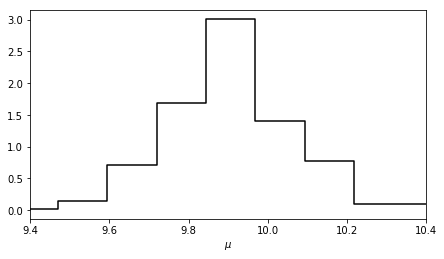

In [7]:
fig = plt.figure(figsize=(10, 10))

hist_mu, bins_mu = np.histogram(trace['mu'], normed=True)

ax = fig.add_axes((0.4, 0.1, 0.55, 0.29))
ax.plot(0.5 * (bins_mu[1:] + bins_mu[:-1]), hist_mu,
         '-k', drawstyle='steps-mid')
ax.set_xlabel(r'$\mu$')
plt.xlim(9.4, 10.4)

plt.show()

###  Use PYMC3 tools to do this for us!

,mean,sd,mc_error,hpd_2.5,hpd_97.5
mu,9.897895,0.176198,0.00473,9.593855,10.232067
sigma,2.129658,0.126131,0.00377,1.943487,2.303383


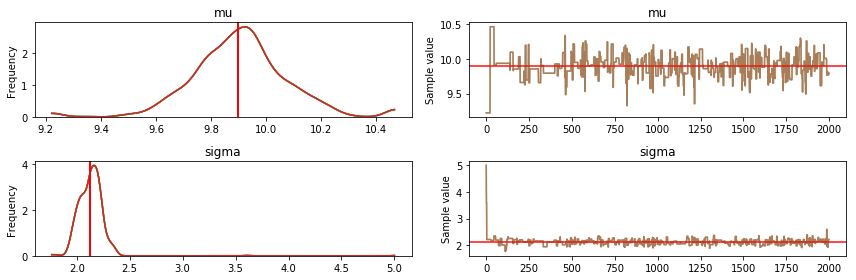

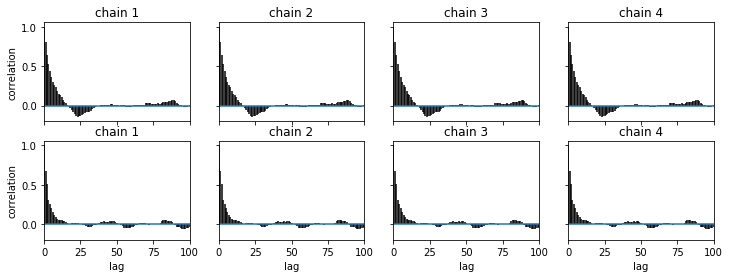

In [8]:
lines = {var:trace[var].mean() for var in trace.varnames}
pm.traceplot(trace, lines= lines)
pm.autocorrplot(trace)
pm.df_summary(trace)

**traceplot** provides
- marginal posterior distribution for each parameter (left)
- the timeseries of the parameter values from the chain (right)

Right hand side shows broad oscillation: both inlying and extreme values occur frequently but at irregular intervals indicating the markov sampler chain was 'well-mixed' (sampling evenly around the optimal position)

**autocorrplot** provides
- correlation between parameters as a function of lag (or separation between steps)
- if you see structure it is showing that the sampler is not travelling the space randomly it depends on the 
    last iteration - features may not be indepdent 

### When to stop

>"Monitoring convergence of iterative simulation is straightforward—discard the first part of the simulations and then compare the variances of quantities of interest within and between chains — and inference given approximate convergence is even simpler; just mix the simulations together and use them as a joint distribution. Both these ideas can and have been refined, but the basic concepts are straightforward and robust.
>
>The hard part is knowing what to do when the simulations are slow to converge."


 > [“Inference from simulations and monitoring convergence” chapter of Handbook of Markov Chain Monte Carlo, Andrew Gelman and Kenneth Shirley](http://www.stat.columbia.edu/~gelman/research/published/GelmanMCMCchapter4.pdf)

** Convergence statistics**

There are a number of proposed statistics for testing convergence

Geweke (1992): Compare the mean of the first fraction and last fraction of a series. The chain is divided into segments and this statistic computed. For convergence the score should vary between -1 and 1.

$$ \frac{E[t_s] - E[t_e]}{\sqrt{V[t_s] + V[t_e]}} $$

with $E[t_s]$ the expaction value and $V[ts]$ the variance of the chain segment

Gelman and Rubin (1992): Compare the variance between multiple chains to the variance within each chain. For convergence between-chain and within-chain variances should be the same. Chains that havent converged have values greater than one. Gelmen and Rubin show that if $\hat{R}$  greater than 1.1 or 1.2 we need longer burn-in.
$$\hat{R} = \frac{\hat{V}}{\hat{W}}$$

with $\hat{W}$ the within chain variance and $\hat{V}$ posterior variance estimate for the pooled traces. 

**Both of these statistics are provided by pymc3**

{'mu': 0.99974996874218514,
 'mu_interval_': 0.99974996874218514,
 'sigma': 0.99974996874218514,
 'sigma_interval_': 0.99974996874218514}

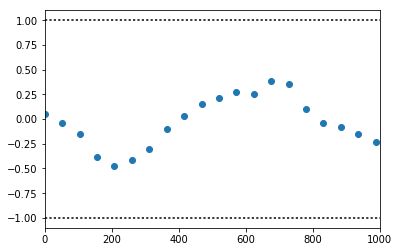

In [9]:
# Geweke diagnostic
g = pm.diagnostics.geweke(trace, intervals=20)
plt.scatter(*g[0]['mu'].T)
plt.hlines([-1,1], 0, 1000, linestyles='dotted')
plt.xlim(0, 1000)

#Gelman-Rubin diagnostic
pm.diagnostics.gelman_rubin(trace)

### Exercise 3: Fit a Cauchy function to data

Repeat the example for the Gaussian but now fit to the data below a Cauchy distribution. Start by defining your own 
priors, set up your likelihood function, choose your sampling technique and build your PYMC model. The two cells below this one provide some plotting routines for showing the marginals of the trace (feel free to use your own - e.g. using seaborn pairgrid)

The Cauchy distribution is given by (two parameters $\gamma$, and $\mu$) and is often used because of its long tailed distributions

$$\frac {1}{\pi \gamma \,\left[1+\left({\frac {x-\mu}{\gamma }}\right)^{2}\right]}$$

<img src="figures/cauchy_distribution.png" alt="cauchy" style="width:600px;"/>

**Describe what happens as you reduce the number of samples**
- for example look at the Gelman-Rubin statistic as you reduce the sample size 

In [10]:
#using PYMC3 to fit Cauchy distribution

# generate observed data
N = 50
np.random.seed(44)
mu_0 = 0
gamma_0 = 2
y = cauchy(mu_0, gamma_0).rvs(N)

nsamples = 2000
with pm.Model() as model:
    #define the priors
    alpha = pm.Uniform('alpha', lower=-5, upper=5)
    beta  = pm.Uniform('beta', lower=0, upper=5)

    # define likelihood - need to write out the p(D|model) as this is Cauchy
    y_obs = pm.Cauchy('y_obs', alpha, beta, observed=y)

    #inference
    #choose our sampling technique
    start = pm.find_MAP()
    step = pm.Metropolis()
    
    trace = pm.sample(nsamples, step, start, random_seed=123, njobs=4, progressbar=True)

Optimization terminated successfully.
         Current function value: 160.560345
         Iterations: 5
         Function evaluations: 8
         Gradient evaluations: 8


100%|██████████| 2000/2000 [00:01<00:00, 1023.54it/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,0.304589,0.534336,0.012828,-0.740460,1.391035
beta,2.500250,0.489964,0.012833,1.638265,3.464976


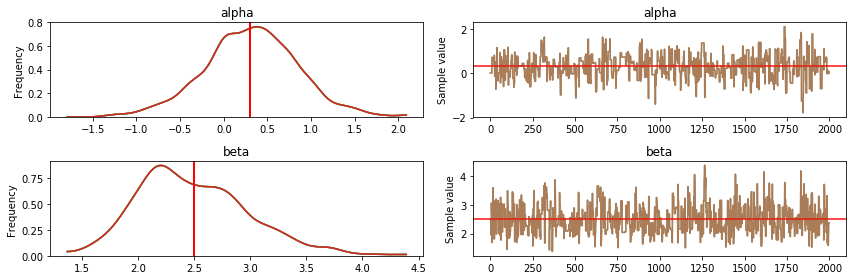

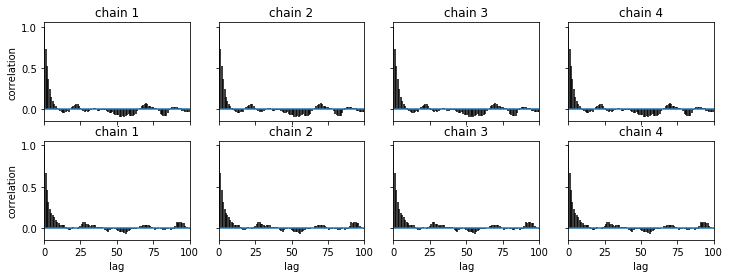

In [11]:
lines = {var:trace[var].mean() for var in trace.varnames}
pm.traceplot(trace, lines= lines)
pm.autocorrplot(trace)
pm.df_summary(trace)

In [12]:
def convert_to_stdev(logL):
    '''
    Given a grid of log-likelihood values, convert them to cumulative
    standard deviation.  This is useful for drawing contours from a
    grid of likelihoods.
    '''
    sigma = np.exp(logL)

    shape = sigma.shape
    sigma = sigma.ravel()

    # obtain the indices to sort and unsort the flattened array
    i_sort = np.argsort(sigma)[::-1]
    i_unsort = np.argsort(i_sort)

    sigma_cumsum = sigma[i_sort].cumsum()
    sigma_cumsum /= sigma_cumsum[-1]

    return sigma_cumsum[i_unsort].reshape(shape)



def plotDistributionsMarginals (trace_x, trace_y, xlim=(-5,5), ylim=(0,5), nbins=41):
    '''Given a set of traces plot the pairwise distributions'''

    bins=(np.linspace(xlim[0], xlim[1], 41), np.linspace(ylim[0], ylim[1], nbins))
    # compute histogram of results to plot below
    L_MCMC, trace_x_bins, trace_y_bins = np.histogram2d(trace_x, trace_y, bins=bins)
    L_MCMC[L_MCMC == 0] = 1E-16  # prevents zero-division errors

    hist_x, bins_x = np.histogram(trace_x, bins=trace_x_bins, normed=True)
    hist_y, bins_y = np.histogram(trace_y, bins=trace_y_bins, normed=True)


    # first axis: likelihood contours
    ax1 = fig.add_axes((0.4, 0.4, 0.55, 0.55))
    ax1.xaxis.set_major_formatter(plt.NullFormatter())
    ax1.yaxis.set_major_formatter(plt.NullFormatter())
    ax1.contour(0.5 * (trace_x_bins[:-1] + trace_x_bins[1:]),
            0.5 * (trace_y_bins[:-1] + trace_y_bins[1:]),
            convert_to_stdev(np.log(L_MCMC.T)),
            levels=(0.683, 0.955, 0.997),
            colors='k')

    # second axis: marginalized over x
    ax2 = fig.add_axes((0.1, 0.4, 0.29, 0.55))
    ax2.xaxis.set_major_formatter(plt.NullFormatter())
    ax2.plot(hist_y, 0.5 * (bins_y[1:] + bins_y[:-1]
                            - bins_y[1] + bins_y[0]), '-k', drawstyle='steps')
    ax2.set_ylabel(r'$Parameter\ x$')
    ax2.set_ylim(ylim[0], ylim[1])

    # third axis: marginalized over y
    ax3 = fig.add_axes((0.4, 0.1, 0.55, 0.29))
    ax3.yaxis.set_major_formatter(plt.NullFormatter())
    ax3.plot(0.5 * (bins_x[1:] + bins_x[:-1]), hist_x, '-k', drawstyle='steps-mid')
    ax3.set_xlabel(r'$Parameter\ y$')
    plt.xlim(xlim[0], xlim[1])



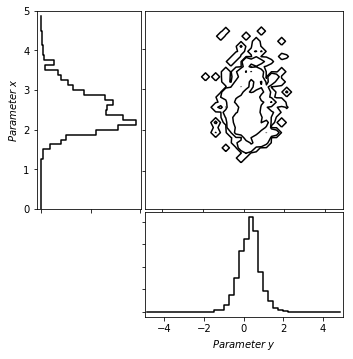

In [13]:
fig = plt.figure(figsize=(5, 5))
plotDistributionsMarginals (trace['alpha'], trace['beta'])


### Lets go further and extend our analysis to other models 

Lets start with regression (infer the expectation value of $y$ given $x$, i.e., the conditional expectation
value). We have all seen the classical maximum likelihood approach for this but we can we can easily use the Bayesian methodology seen earlier this week to write the posterior pdf for the model parameters

$$p({\theta}|x,y,I) \propto p(x,y | {\theta}, I) \,
p({\theta}, I)$$

Here the information $I$ describes the error behavior for the dependent
variable. If the $y$ error distribution is
Gaussian, with the width for $i$th data point given by $\sigma_i$,
and the errors on $x$ are negligible,  then 

$$ p(y_i|x_i,{\theta}, I) =  {1 \over \sigma_i \sqrt{2\pi}} \, \exp{\left({-[y_i-f(x_i|{\theta})]^2 \over 2 \sigma_i^2}\right)} $$

**So y is a random variable with a normal distribution with a mean predicted by the model. We estimate the posterior for the model parameters as well as the variance in the data (also a probablity distribution)**

## Lets start with a simple linear regression 

$$y_i =\theta_0 + \theta_1x_{i1} + \epsilon_i$$

and fit the parameters $\theta_1$ and $\theta_0$

we will initially assume that there are homoskedastic errors (all points have the same error) and will learn this error as part of the model


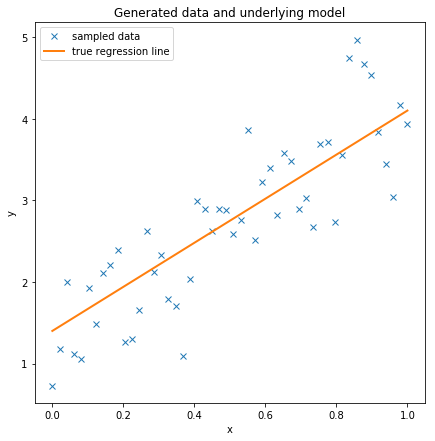

In [14]:
size = 50
intercept = 1.4
slope = 2.7

x = np.linspace(0, 1, size)

# y = a + b*x
model_y = intercept + slope * x

# add noise
y_err = np.random.normal(scale=.5, size=size)
y = model_y + y_err
data = dict(x=x, y=y)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(x, y, 'x', label='sampled data')
ax.plot(x, model_y, label='true regression line', lw=2.)
plt.legend(loc=0)

### Do it yourself regression using PYMC

Optimization terminated successfully.
         Current function value: 45.707455
         Iterations: 12
         Function evaluations: 18
         Gradient evaluations: 18


100%|██████████| 1000/1000 [00:14<00:00, 69.08it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd57bba8198>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fd582be3198>]], dtype=object)

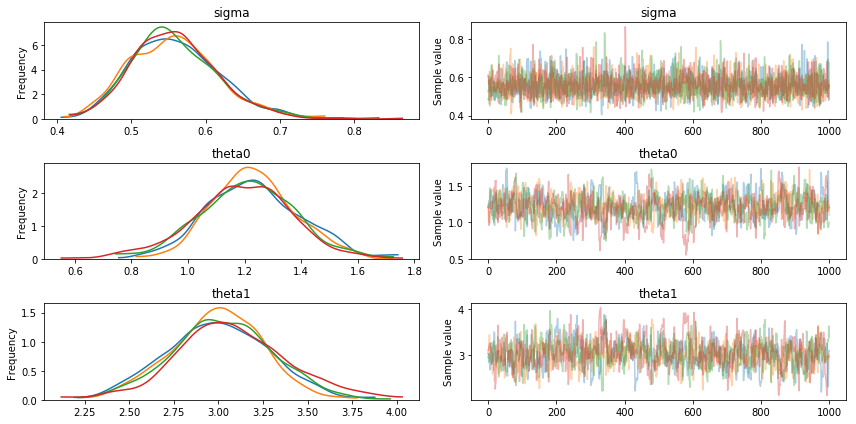

In [19]:
nsample = 1000

with pm.Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = pm.HalfNormal('sigma', sd=10)
    theta0 = pm.Uniform('theta0', lower=0, upper=5)
    theta1 = pm.Uniform('theta1', lower=0, upper=5)

    # Define likelihood
    likelihood = pm.Normal('y', mu=theta0 + theta1*x, \
                        sd=sigma, observed=y)   
    # Inference
    start = pm.find_MAP() # Find starting value by optimization
    step = pm.NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    trace = pm.sample(nsample, step, start=start, progressbar=True, njobs=4) # run with 4 cores

pm.traceplot(trace)

In [17]:
pm.df_summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
sigma,0.558638,0.059441,0.001166,0.450709,0.674810
B,1.207304,0.149804,0.005597,0.901988,1.483765
M,3.035656,0.259176,0.009642,2.525533,3.511858


### Now lets plot the predictive posterior samples to see how the distributions of fits varies

KeyError: 'theta1'

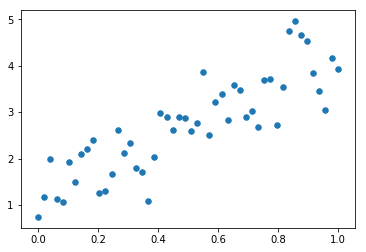

In [18]:
### Plot the predictive posterior samples
plt.scatter(x, y, s=30, label='data')
for a_, b_ in zip(trace['theta1'][-500:], trace['theta0'][-500:]):
    plt.plot(x, a_*x +b_, c='gray', alpha=0.1)

### PYMC3 makes the model fitting easier with the GLM (generalized linear models) package

Very similar to the example before except we express the model using the [patsy](http://patsy.readthedocs.io/en/latest/overview.html) Python package (which can easily describe statistical models and create the associated design matrix)

patsy is a Python package for describing statistical models (especially linear models, or models that have a linear component) and building design matrices (the syntax is borrowed from R). For example

<img src="figures/formula-structure.png" alt="patsy" style="width:600px;"/>





$$y \sim np.power(x, 2) + x$$

Would generate a model for a polynomial regression that included x$^2$, x, and an intercept **Note** the intercepts are not specified within the model 

For our linear model the Patsy formula is y~x. glm() parses the  model, adds the random variables (slope and intercept), creates a likelihood (Normal distribution is default), and adds other variables (e.g. sigma). glm() also initializes the parameters (e.g. what find_MAP() had previously done).

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 99%|█████████▉| 10428/10500 [00:12<00:00, 880.56it/s]/Users/ajc/miniconda3/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.883749301916, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 10500/10500 [00:12<00:00, 835.35it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122985a20>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1240f8f98>]], dtype=object)

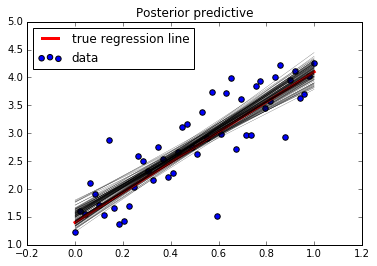

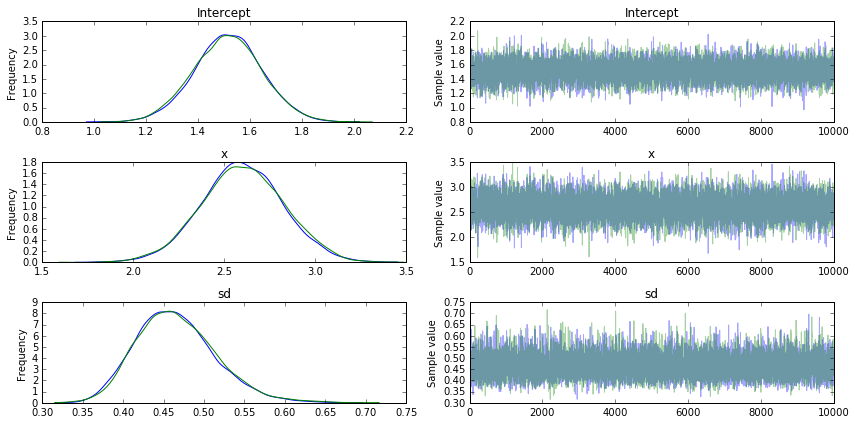

In [12]:
#Using GLM to fit a linear model
nsamples = 10000
with pm.Model() as model:
    pm.glm.GLM.from_formula('y ~ x', data)
    step = pm.NUTS()
    trace = pm.sample(nsamples, njobs=2)
    
plt.scatter(x, y, s=30, label='data')
plt.plot(x, slope*x + intercept, label='true regression line', lw=3., c='red')
plt.legend(loc='best')

pm.plot_posterior_predictive_glm(trace, samples=100, 
                                 label='posterior predictive regression lines')
pm.traceplot(trace)

### Regression with uncertainities 

We can now extend the examples to include uncertainties within the data. For this we will use the [Hogg, Bovy, and Lang](https://arxiv.org/abs/1008.4686) data set and base our answers on the [notebooks](https://github.com/pymc-devs/pymc3/blob/master/docs/source/notebooks/) in the pymc3 repository


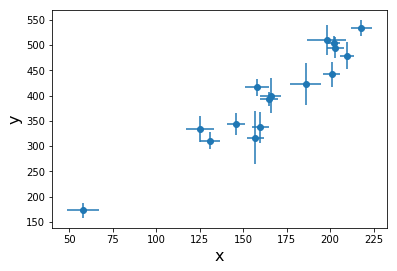

In [24]:
#read in the Hogg data (initially exclude the 4 outlier data points)
data = np.load('hoggData.npy')
x = data['x'][4:]
y = data['y'][4:]
sigma_x = data['sigma_x'][4:]
sigma_y = data['sigma_y'][4:]
plt.scatter(x, y, c='k', s=9)
plt.errorbar(x, y, yerr=sigma_y, xerr=sigma_x, fmt='o')
plt.xlabel('x',fontsize=16)
plt.ylabel('y',fontsize=16)

### Exercise 4: build a regression model for the Hogg data

Repeat the earlier analysis and learn the variance of the data

Optimization terminated successfully.
         Current function value: 91.144237
         Iterations: 23
         Function evaluations: 34
         Gradient evaluations: 34


100%|██████████| 2000/2000 [00:32<00:00, 61.29it/s] 


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd5884ceb38>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fd57b46c208>]], dtype=object)

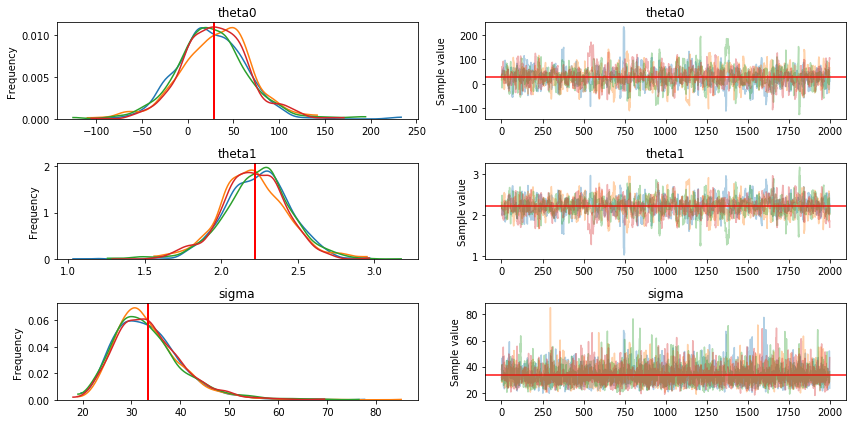

In [31]:
nsample=2000
with pm.Model() as model:
    ## Define weakly informative Normal priors to give Ridge regression
    sigma = pm.HalfNormal('sigma', sd=100)
    theta0 = pm.Normal('theta0', mu=0, sd=300)
    theta1 = pm.Normal('theta1', mu=0, sd=300)
    ## Define linear model
    
    linear_model = theta0 + theta1 * x
    
    ## Define Normal likelihood
    
    likelihood = pm.Normal('likelihood', mu=linear_model, sd=sigma, observed=y)
    
    # Inference!
    start = pm.find_MAP() # Find starting value by optimization
    step = pm.NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    trace = pm.sample(nsample, step, start=start, progressbar=True, njobs=4) # run with 4 cores

    
lines = {var:trace[var].mean() for var in trace.varnames}
pm.traceplot(trace, lines=lines)

<Container object of 3 artists>

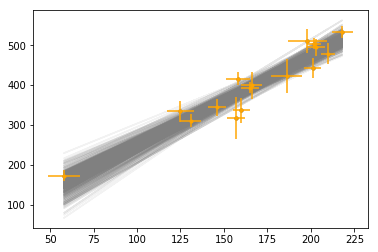

In [35]:
for a_, b_ in zip(trace['theta1'][-500:], trace['theta0'][-500:]):
    plt.plot(x, a_*x + b_, c='gray', alpha=0.1)
plt.scatter(x, y, c='k', s=9)
plt.errorbar(x, y, yerr=sigma_y, xerr=sigma_x, fmt='.', zorder=10, color='orange')

### Now lets incorporate uncertainties from the data points themselves

Optimization terminated successfully.
         Current function value: 85.410730
         Iterations: 5
         Function evaluations: 9
         Gradient evaluations: 9


100%|██████████| 1000/1000 [00:20<00:00, 134.52it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd5747a4780>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fd571b0cef0>]], dtype=object)

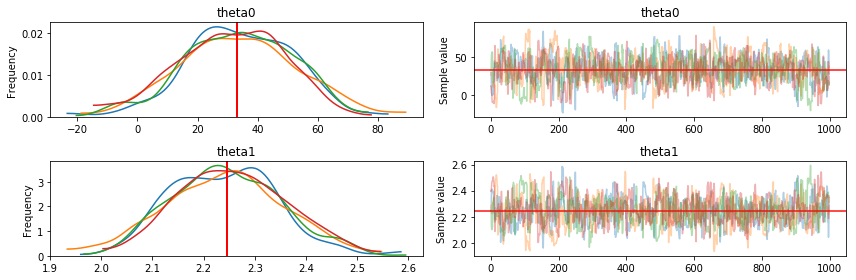

In [36]:
#repeat using y errors
nsample=1000
with pm.Model() as model:
    ## Define weakly informative Normal priors to give Ridge regression
    theta0 = pm.Normal('theta0', mu=0, sd=100) # why normal
    theta1 = pm.Normal('theta1', mu=0, sd=100)

    ## Define linear model
    yest = theta0 +  theta1* x
    
    ## Use y error from dataset, convert into theano variable
    thea_sigma_y = thea.shared(np.asarray(sigma_y, dtype=thea.config.floatX), name='sigma_y')

    ## Define Normal likelihood
    likelihood = pm.Normal('likelihood', mu=yest, sd=thea_sigma_y, observed=y)    

    # Inference!
    start = pm.find_MAP() # Find starting value by optimization
    step = pm.NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    trace = pm.sample(nsample, step, start=start, progressbar=True, njobs=4) # run with 4 cores

lines = {var:trace[var].mean() for var in trace.varnames}
pm.traceplot(trace, lines=lines)

<Container object of 3 artists>

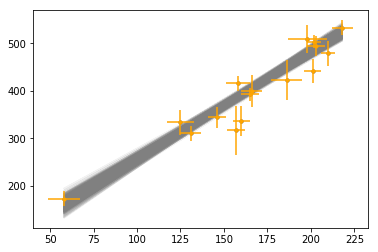

In [37]:
#plt.scatter(x, y, c='k', s=9)
#plt.errorbar(x, y, yerr=sigma_y, xerr=sigma_x, fmt='o')
for a_, b_ in zip(trace['theta1'][-500:], trace['theta0'][-500:]):
    plt.plot(x, a_*x + b_, c='gray', alpha=0.1)
    
plt.scatter(x, y, c='k', s=9)
plt.errorbar(x, y, yerr=sigma_y, xerr=sigma_x, fmt='.', zorder=10, color='orange')

### Outlier rejection

The  L2 norm (assuming the likelihood has a normal distribution) is sensitive to outliers (i.e. it squares the residuals). A number of approaches exist for correcting for outliers. These include "sigma-clipping", using interquartile ranges, and taking the median of solutions of subsets of the data

Other approaches include changing the likelihood function to one that allows for longer tails or assuming that the data are drawn from two Gaussians error distribution (one for the function and the other for the outliers)

$\mathcal{logL} = \sum_{i}^{i=N} log \left[ \frac{(1 - B_{i})}{\sqrt{2 \pi \sigma_{in}^{2}}} exp \left( - \frac{(x_{i} - \mu_{in})^{2}}{2\sigma_{in}^{2}} \right) \right] + \sum_{i}^{i=N} log \left[ \frac{B_{i}}{\sqrt{2 \pi (\sigma_{in}^{2} + \sigma_{out}^{2})}} exp \left( - \frac{(x_{i}- \mu_{out})^{2}}{2(\sigma_{in}^{2} + \sigma_{out}^{2})} \right) \right]$

where:

$\bf{B}$ is Bernoulli-distibuted $B_{i} \in [0_{(inlier)},1_{(outlier)}]$

If we use MCMC we can marginalize over the nuisance parameters  $B$ ,  $\sigma_{out}$, $\mu_{out}$. We could also calculate the probability that a point is drawn from the outlier or "model" Gaussian.

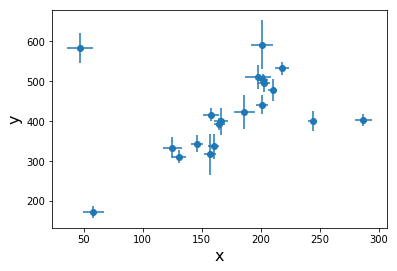

In [55]:
x = data['x']
y = data['y']
sigma_x = data['sigma_x']
sigma_y = data['sigma_y']
plt.scatter(x, y, c='k', s=9)
plt.errorbar(x, y, yerr=sigma_y, xerr=sigma_x, fmt='o')
plt.xlabel('x',fontsize=16)
plt.ylabel('y',fontsize=16)

Optimization terminated successfully.
         Current function value: 142.333344
         Iterations: 52
         Function evaluations: 78
         Gradient evaluations: 78


100%|██████████| 2000/2000 [00:49<00:00, 40.07it/s] 


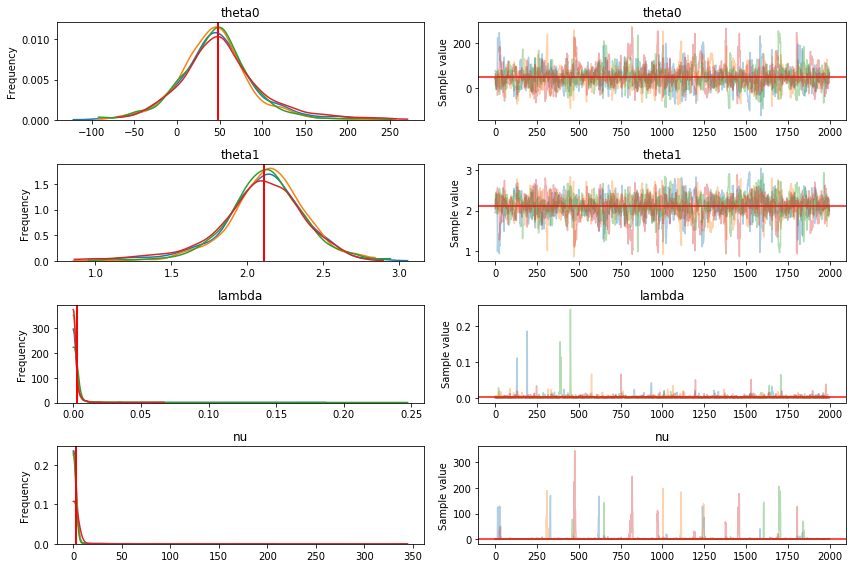

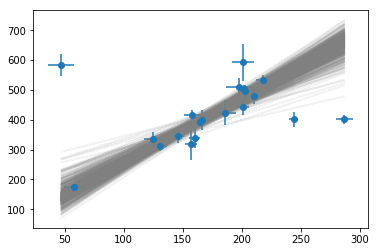

In [56]:
nsample=2000
with pm.Model() as model:
    ## Define weakly informative Normal priors to give Ridge regression
    theta0 = pm.Normal('theta0', mu=0, sd=100)
    theta1 = pm.Normal('theta1', mu=0, sd=100)
    
    lamda = pm.HalfNormal('lambda', sd=100)
    nu = pm.HalfNormal('nu', sd=100)

    ## Define linear model
    yest = theta0 +  theta1* x
    
    # Use y error from dataset, convert into theano variable
    thea_sigma_y = thea.shared(np.asarray(sigma_y, dtype=thea.config.floatX), name='sigma_y')

    ## Define Normal likelihood
    #likelihood = pm.Normal('likelihood', mu=yest, sd=thea_sigma_y, observed=y)    
    likelihood = pm.StudentT('likelihood', mu=yest, lam=lamda, nu=nu, observed=y)    

    # Inference!
    start = pm.find_MAP() # Find starting value by optimization
    step = pm.NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    trace = pm.sample(nsample, step, start=start, progressbar=True, njobs=4) # run with 4 cores

lines = {var:trace[var].mean() for var in trace.varnames}
pm.traceplot(trace, lines=lines)

plt.figure()
plt.scatter(x, y, c='k', s=9)
plt.errorbar(x, y, yerr=sigma_y, xerr=sigma_x, fmt='o')
for a_, b_ in zip(trace['theta1'][-500:], trace['theta0'][-500:]):
    plt.plot(x, a_*x + b_, c='gray', alpha=0.1)

### Exercise 5: develop a robust regression using likelihood and priors

You have seen the example of the Huber loss function. When we use a normal likelihood function excursions are weighted heavily (by the square of the deviation). If we consider that the distribution of residuals is not described by a Gaussian come up with a way to reduce the impact of outliers in the model fit

In [ ]:
#robust regression
nsample=2000
with pm.Model() as model:
    ## Define weakly informative Normal priors to give Ridge regression
    theta0 = pm.Normal('theta0', mu=0, sd=100)
    theta1 = pm.Normal('theta1', mu=0, sd=100)

    ## Define linear model
    yest = theta0 +  theta1* x
    
    ## Use y error from dataset, convert into theano variable
    thea_sigma_y = thea.shared(np.asarray(sigma_y, dtype=thea.config.floatX), name='sigma_y')

    ## Define the likelihood

    
    # Inference
    trace = pm.sample(nsample, step, start=start, progressbar=True, njobs=4) # run with 4 cores

lines = {var:trace[var].mean() for var in trace.varnames}
pm.traceplot(trace, lines=lines)

plt.figure()
plt.scatter(x, y, c='k', s=9)
plt.errorbar(x, y, yerr=sigma_y, xerr=sigma_x, fmt='o')
for a_, b_ in zip(trace['theta1'][-500:], trace['theta0'][-500:]):
    plt.plot(x, a_*x + b_, c='gray', alpha=0.1)

### Modelling outliers

Assume the data are drawn from two Gaussians error distribution (one for the function and the other for the outliers)

$\mathcal{logL} = \sum_{i}^{i=N} log \left[ \frac{(1 - B_{i})}{\sqrt{2 \pi \sigma_{in}^{2}}} exp \left( - \frac{(x_{i} - \mu_{in})^{2}}{2\sigma_{in}^{2}} \right) \right] + \sum_{i}^{i=N} log \left[ \frac{B_{i}}{\sqrt{2 \pi (\sigma_{in}^{2} + \sigma_{out}^{2})}} exp \left( - \frac{(x_{i}- \mu_{out})^{2}}{2(\sigma_{in}^{2} + \sigma_{out}^{2})} \right) \right]$



In [95]:
import theano.tensor as T 
def logp_signoise(yobs, is_outlier, yest_in, sigma_y_in, yest_out, sigma_y_out):
    '''
    Define custom loglikelihood for inliers vs outliers. 
    NOTE: in this particular case we don't need to use theano's @as_op 
    decorator because (as stated by Twiecki in conversation) that's only 
    required if the likelihood cannot be expressed as a theano expression.
    We also now get the gradient computation for free.
    '''   
    
    # likelihood for inliers
    pdfs_in = T.exp(-(yobs - yest_in + 1e-4)**2 / (2 * sigma_y_in**2)) 
    pdfs_in /= T.sqrt(2 * np.pi * sigma_y_in**2)
    logL_in = T.sum(T.log(pdfs_in) * (1 - is_outlier))

    # likelihood for outliers
    pdfs_out = T.exp(-(yobs - yest_out + 1e-4)**2 / (2 * (sigma_y_in**2 + sigma_y_out**2))) 
    pdfs_out /= T.sqrt(2 * np.pi * (sigma_y_in**2 + sigma_y_out**2))
    logL_out = T.sum(T.log(pdfs_out) * is_outlier)

    return logL_in + logL_out

In [96]:
with pm.Model() as mdl_signoise:
    
    ## Define weakly informative Normal priors to give Ridge regression
    theta0 = pm.Normal('theta0', mu=0, sd=10, testval=pm.floatX(0.1))
    theta1 = pm.Normal('theta1', mu=0, sd=10, testval=pm.floatX(1.))
 
    ## Define linear model
    yest_in = theta0 + theta1 * x

    ## Define weakly informative priors for the mean and variance of outliers
    yest_out = pm.Normal('yest_out', mu=0, sd=100, testval=pm.floatX(1.))
    sigma_y_out = pm.HalfNormal('sigma_y_out', sd=100, testval=pm.floatX(1.))

    ## Define Bernoulli inlier / outlier flags according to a hyperprior 
    ## fraction of outliers, itself constrained to [0,.5] for symmetry
    frac_outliers = pm.Uniform('frac_outliers', lower=0., upper=.5)
    is_outlier = pm.Bernoulli('is_outlier', p=frac_outliers, shape=x.shape[0], 
                              testval=np.random.rand(x.shape[0]) < 0.2)
    
    ## Extract observed y and sigma_y from dataset, encode as theano objects
    yobs = thea.shared(np.asarray(y, dtype=thea.config.floatX), name='yobs')
    sigma_y_in = thea.shared(np.asarray(sigma_y, dtype=thea.config.floatX), 
                             name='sigma_y_in')
        
    ## Use custom likelihood using DensityDist
    likelihood = pm.DensityDist('likelihood', logp_signoise,
                        observed={'yobs': yobs, 'is_outlier': is_outlier,
                                  'yest_in': yest_in, 'sigma_y_in': sigma_y_in,
                                  'yest_out': yest_out, 'sigma_y_out': sigma_y_out})

In [97]:
with mdl_signoise:
    ## two-step sampling to create Bernoulli inlier/outlier flags
    step1 = pm.Metropolis([frac_outliers, yest_out, sigma_y_out, theta0, theta1])
    step2 = pm.step_methods.BinaryGibbsMetropolis([is_outlier])

    ## take samples
    traces_signoise = pm.sample(20000, step=[step1, step2], tune=10000, progressbar=True)

100%|██████████| 30000/30000 [05:48<00:00, 86.14it/s]


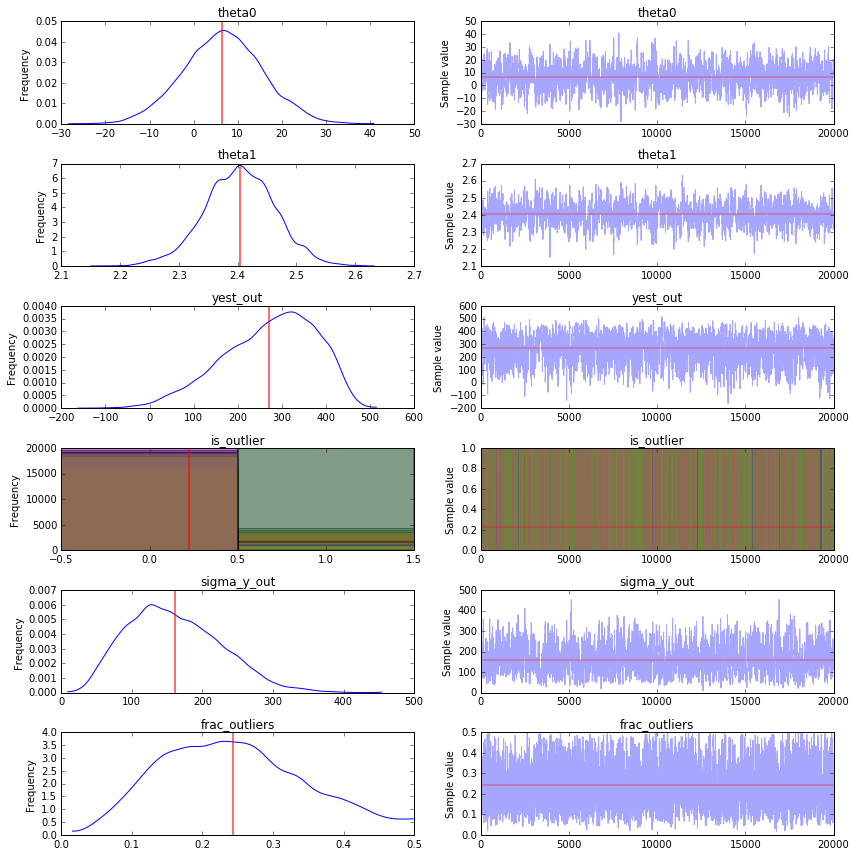

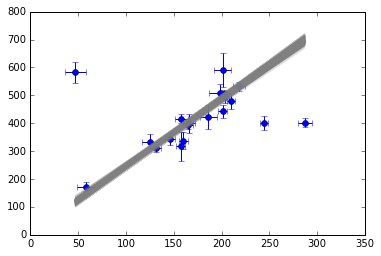

In [41]:
lines = {var:traces_signoise[var].mean() for var in traces_signoise.varnames}
pm.traceplot(traces_signoise, lines=lines)

plt.figure()
plt.scatter(x, y, c='k', s=9)
plt.errorbar(x, y, yerr=sigma_y, xerr=sigma_x, fmt='o')
for a_, b_ in zip(traces_signoise['theta1'][-500:], traces_signoise['theta0'][-500:]):
    plt.plot(x, a_*x + b_, c='gray', alpha=0.1)

For small numbers of data points and large numbers of parameters we run into issues with overfitting. Defining priors on the parameters values (e.g., constraining the absolute or squared distance of the parameters) can alleviate some of these issues. This

For example 

Ridge regression: $p(\theta | I ) \propto \exp{\left(\frac{-(\lambda \theta^T \theta)^2}{2}\right)}$

LASSO regression: $p(\theta | I ) \propto \exp{\left(\frac{-(\lambda \theta^T \theta)}{2}\right)}$

the regularization parameter $\lambda$ can be learnt from the data

### Exercise 6: how does the regression change as we increase the order of the polynomial we are fitting

Increase the order of the regression (a polynomial fit). Determine when you start overfitting the data. Take the examples of the regularization and thinking about priors. How would you reduce the oscillations in the fits using different forms of prior?

### Exercise 7: Putting it all together

Using pymc3 fit a set of Gaussians to the following data (with fixed variance and positions) and show how the data become overfit as the number of Gaussians increases. Add a prior that constrains the fit parameters.



/Users/ajc/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


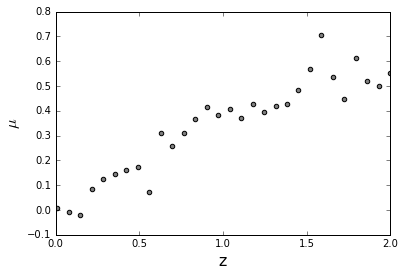

In [83]:
#----------------------------------------------------------------------
# generate data
def cosmo(z):
    return z*z*np.exp(-z)

nData= 30
z = np.linspace(0.01, 2, nData)
mu = np.array(list(map(cosmo, z))) + np.random.normal(scale=0.06, size=len(z))


#define the gaussian functions and their centers/widths
def gaussian_basis(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / sigma) ** 2)

nGaussians = 30 
centers = np.linspace(0, 1.8, nGaussians)
widths = 0.2

plt.scatter(z, mu, s=20, c='gray')
plt.xlim([0., 2.])
plt.xlabel('z',fontsize=16)
plt.ylabel('$\mu$',fontsize=16);